# 1. Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (24, 10)
sns.set(style="darkgrid")
sns.set(font_scale=1.5)

# 2. Utils

Ces fonctions nous seront utiles pour la suite du projet

In [3]:
def bar_chart(dataframe, feature):
    """
    Plots a bar chart that exhibits the relationship between categorical features and 'click'.
    """
    pd.crosstab(dataframe[feature], dataframe['click']).plot(
        kind='bar', stacked=True)
    plt.title('Number of clicks by {}'.format(feature))
    plt.xlabel(feature)
    plt.ylabel('Number of clicks')
    plt.show()

In [4]:
def lattice_plot(dataframe, feature, interval=None):
    """
    Plots a lattice plot that exhibits the relationship between quantitative features and 'click'.
    """
    facet = sns.FacetGrid(dataframe, hue='click', height=6, aspect=2)
    facet.map(sns.kdeplot, feature, shade=True)
    if interval is None:
        interval = [min(dataframe[feature]), max(dataframe[feature])]

    facet.set(xlim=(interval[0], interval[1]))
    facet.add_legend()
    plt.title("clicks by '{colname}' feature in the interval {interval}".format(colname=feature, interval=interval))
    
    plt.show()

In [5]:
def dummy_df(dataframe, todummy_list):
    """
    Dummies the given columns of the dataframe.
    --
    Arguments:
        dataframe: pandas dataframe
        todummy_list: list of dataframe columns to be dummied.
    Returns:
        dataframe: pandas dataframe with the dummied columns.
    """
    for category in todummy_list:
        dummies = pd.get_dummies(dataframe[category], prefix=category, dummy_na=False)
        dataframe = dataframe.drop(category, 1)
        dataframe = pd.concat([dataframe, dummies], axis=1)
        
    return dataframe

# 3. Pré-traitement et exploration du jeu de données

In [6]:
# importation du dataset en un pandas dataframe
data = pd.read_csv('data/test_campaign.csv')

In [7]:
data.shape

(576037, 16)

On dispose de 576037 exemples, avec 15 variables indépendantes (features), et une variable d'intérêt catégorique.

Donc on est face a un problème de <b>classification binaire</b>.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576037 entries, 0 to 576036
Data columns (total 16 columns):
fold_position           576037 non-null int64
buyer_bid               575962 non-null float64
geo_region              576037 non-null int64
operating_system        576037 non-null int64
browser                 576037 non-null int64
advertiser_frequency    576037 non-null int64
advertiser_recency      576037 non-null int64
campaign_id             576037 non-null int64
creative_id             576037 non-null int64
creative_freq           576037 non-null int64
creative_rec            576037 non-null int64
geo_dma                 576037 non-null int64
geo_city                576037 non-null int64
device_type             576037 non-null int64
geo_postal_code         576037 non-null int64
click                   576037 non-null int64
dtypes: float64(1), int64(15)
memory usage: 70.3 MB


Les 15 variables indépendantes sont réparties comme suit:


| Variables quantitatives | Variables catégoriques |
|------|------|
|   buyer_bid  | fold_position |
|   advertiser_frequency  | geo_region |
|   advertiser_recency  | operating_system |
|   creative_freq  | browser |
|   creative_rec  | geo_dma |
|   - | geo_city |
|   - | device_type |
|   - | geo_postal_code |
|   - | campaign_id |
|   - | creative_id |


La variable d'intérêt est 'click', et est une variable catégorique qui prend des valeurs dans {0, 1}.



## 3.1 Valeurs manquantes

In [9]:
data.isnull().sum()

fold_position            0
buyer_bid               75
geo_region               0
operating_system         0
browser                  0
advertiser_frequency     0
advertiser_recency       0
campaign_id              0
creative_id              0
creative_freq            0
creative_rec             0
geo_dma                  0
geo_city                 0
device_type              0
geo_postal_code          0
click                    0
dtype: int64

Puisqu'on dispose de suffisamment d'exemples, les valeurs manquantes seront supprimées au lieu de les remplacer par  la médiane.

In [10]:
data = data.dropna()

In [11]:
data.shape

(575962, 16)

In [12]:
data.isnull().sum()

fold_position           0
buyer_bid               0
geo_region              0
operating_system        0
browser                 0
advertiser_frequency    0
advertiser_recency      0
campaign_id             0
creative_id             0
creative_freq           0
creative_rec            0
geo_dma                 0
geo_city                0
device_type             0
geo_postal_code         0
click                   0
dtype: int64

Le problème des valeurs manquantes est corrigé.

## 3.2 Correction de la feature 'click'

La variable 'click' doit prendre une valeur dans {0, 1}. 

On remarque qu'une ligne prend une valeur autre que 0 ou 1. On va donc la supprimer.

In [13]:
print('La variable \'click\' prend les valeurs: ', str(data['click'].unique()))

La variable 'click' prend les valeurs:  [      0       1 5748394]


In [14]:
print(
    'Le nombre de lignes où la variable \'click\' n\'est pas dans {0, 1} est =',
    len(data[(data['click'] != 0) & (data['click'] != 1)]))

Le nombre de lignes où la variable 'click' n'est pas dans {0, 1} est = 1


In [15]:
# suppression de la ligne indésirable
data = data.drop(data[(data['click'] != 0) & (data['click'] != 1)].index)

In [16]:
print(
    'Le nombre de lignes où la variable \'click\' n\'est pas dans {0, 1} est =',
    len(data[(data['click'] != 0) & (data['click'] != 1)]))

Le nombre de lignes où la variable 'click' n'est pas dans {0, 1} est = 0


## 3.3 Distribution du jeu de données

In [17]:
clicks_mean = data['click'].mean()
print("Seulement {0:.0%} des pubs ont enregisté un clic.".format(clicks_mean))

Seulement 8% des pubs ont enregisté un clic.


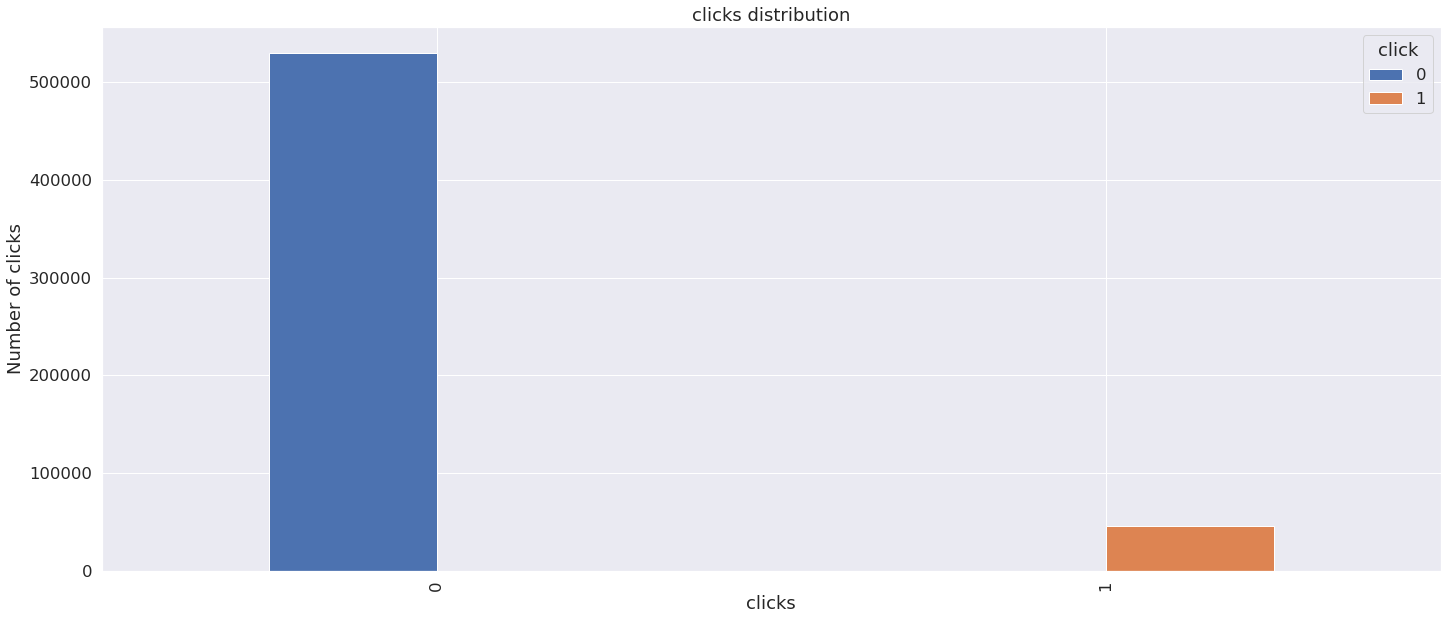

In [18]:
pd.crosstab(data['click'], data['click']).plot(kind='bar')
plt.title('clicks distribution')
plt.xlabel('clicks')
plt.ylabel('Number of clicks')
plt.show()

On a un déséquilibre de classes dans notre jeu de données qu'on doit corriger avant la phase d'entraînement, plus précisement après le train/test split, où on va utiliser un algorithme d'oversampling et/ou undersampling pour équilibrer la partie train du dataset.

## 3.4 Influence des variables catégoriques sur la variable d'intérêt 'click'

### 3.4.1 fold_position:

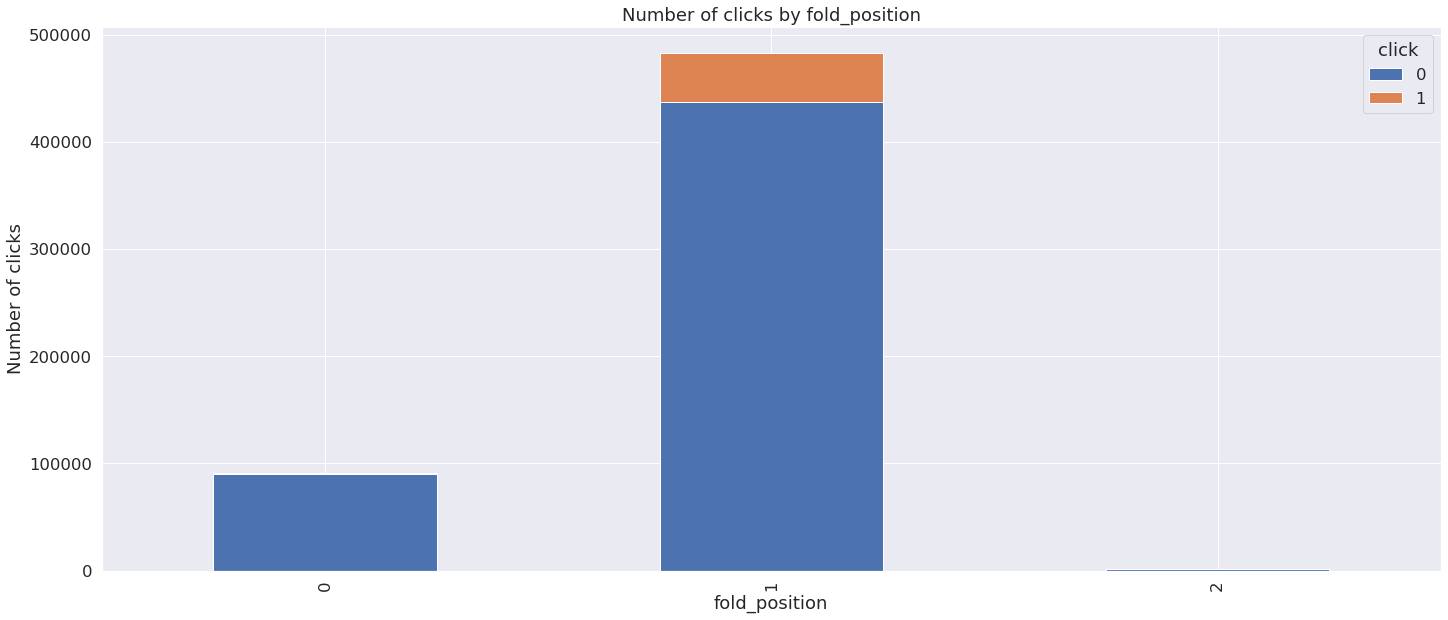

In [19]:
bar_chart(data, 'fold_position')

On propose de faire une transformation qui va consister en garder juste la fold_position (1), les autres feront parties d'une même catégorie qu'on nommera (0).

In [20]:
# définition du critère et la valeur lui correspondant
criteria = [data['fold_position'].isin([1])]
values = [1]

# Application du critère à la colonne en question
data['fold_position'] = np.select(criteria, values, default=0)

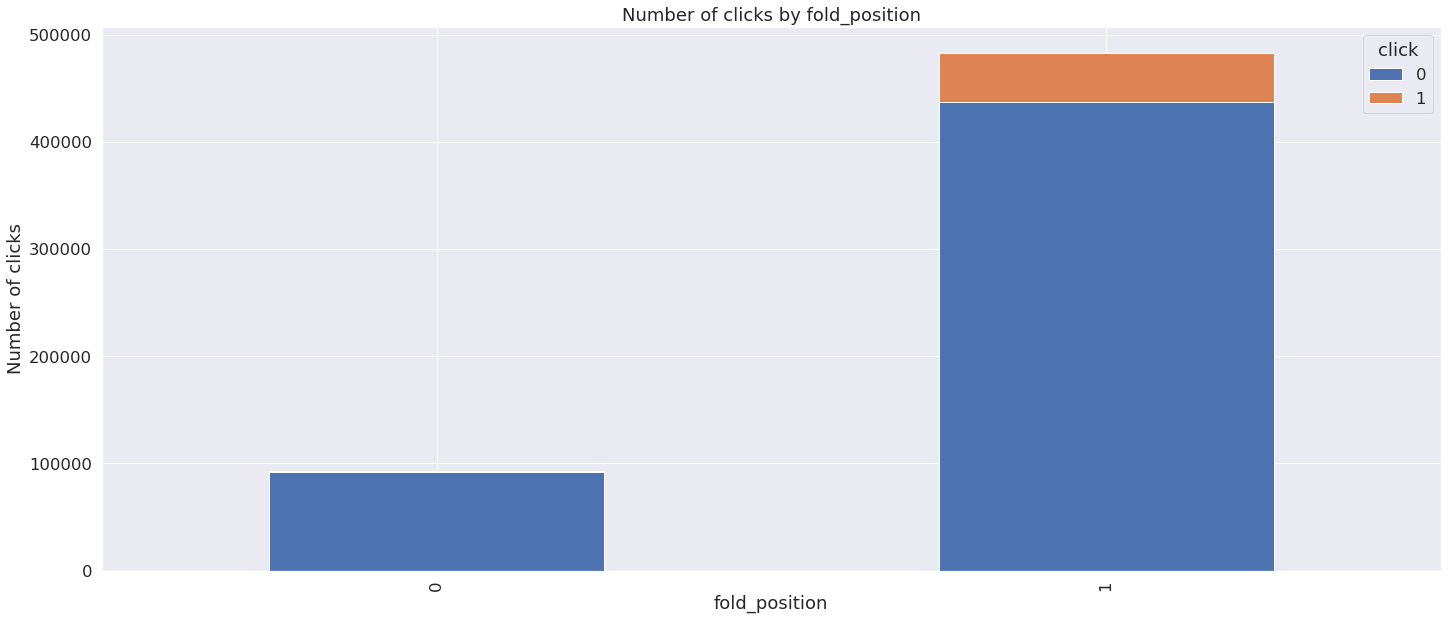

In [21]:
bar_chart(data, 'fold_position')

Le nombre de clicks varie avec la fold_position, du coup cette dernière fera partie de nos features.

### 3.4.2 geo_region:

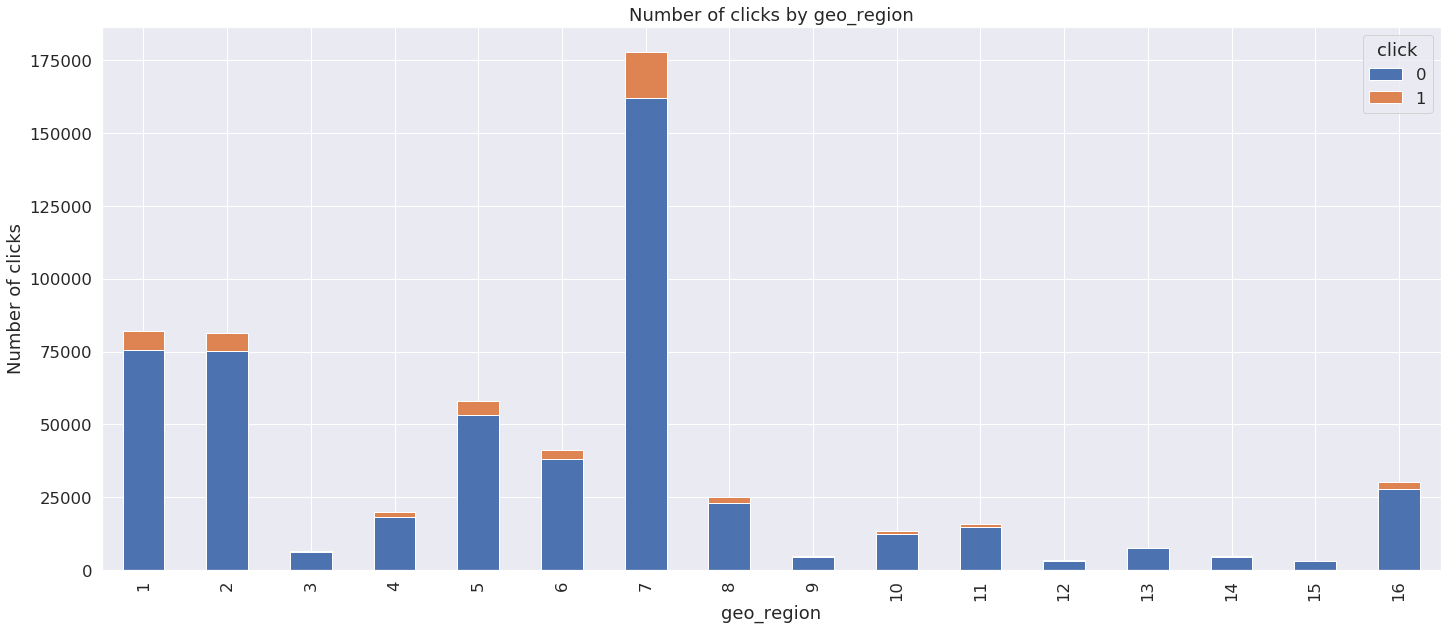

In [22]:
bar_chart(data, 'geo_region')

On propose de faire une transformation sur cette feature. On va créer de nouvelles catégories à partir de celle-ci.<br>
On va créer:
    - une catégorie (1) pour la région 7,
    - une catégorie (2) pour les régions 1, 2,
    - une catégorie (0) pour tout le reste.

In [23]:
data['geo_region'].head()

0     2
1     8
2    10
3     5
4     1
Name: geo_region, dtype: int64

In [24]:
criteria = [data['geo_region'].isin([7]), data['geo_region'].isin([1, 2])]
values = [1, 2]

data['geo_region'] = np.select(criteria, values, default=0)

In [25]:
data['geo_region'].head()

0    2
1    0
2    0
3    0
4    2
Name: geo_region, dtype: int64

La transformation a bien été effectuée.

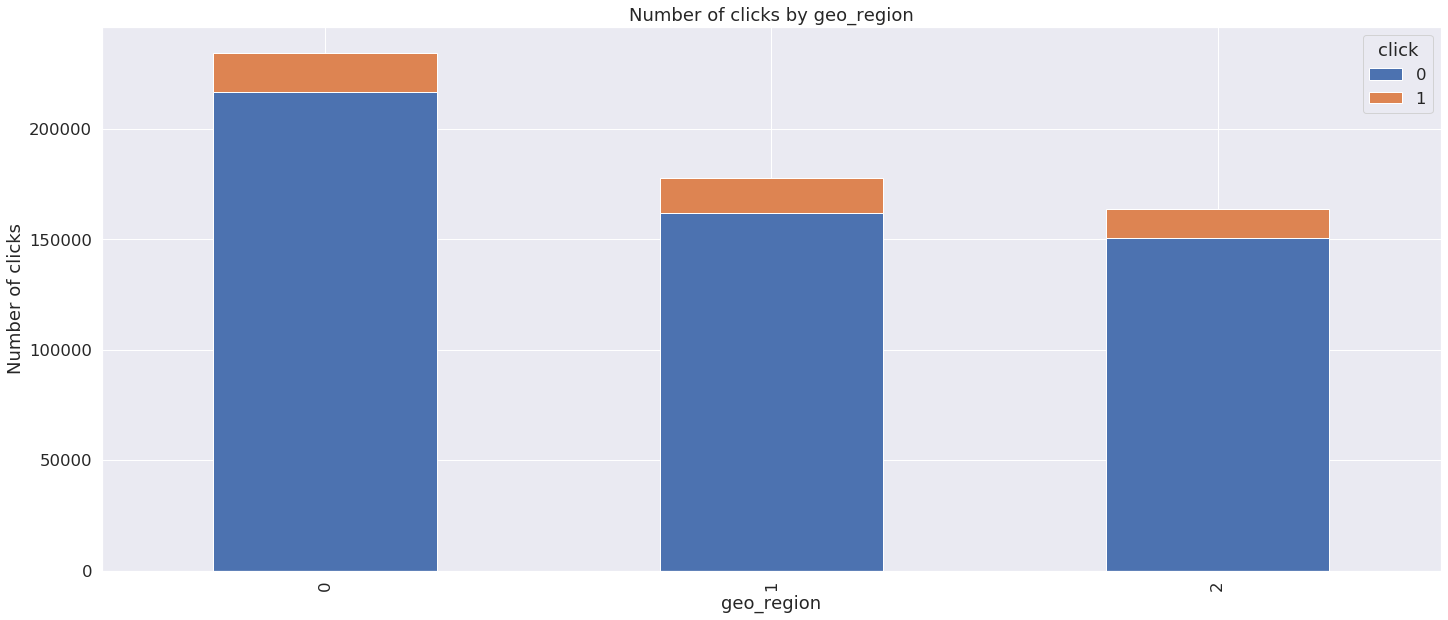

In [26]:
bar_chart(data, 'geo_region')

Les clicks varient suivant la geo_region. C'est donc une feature à envisager.

### 3.4.3 operating_system

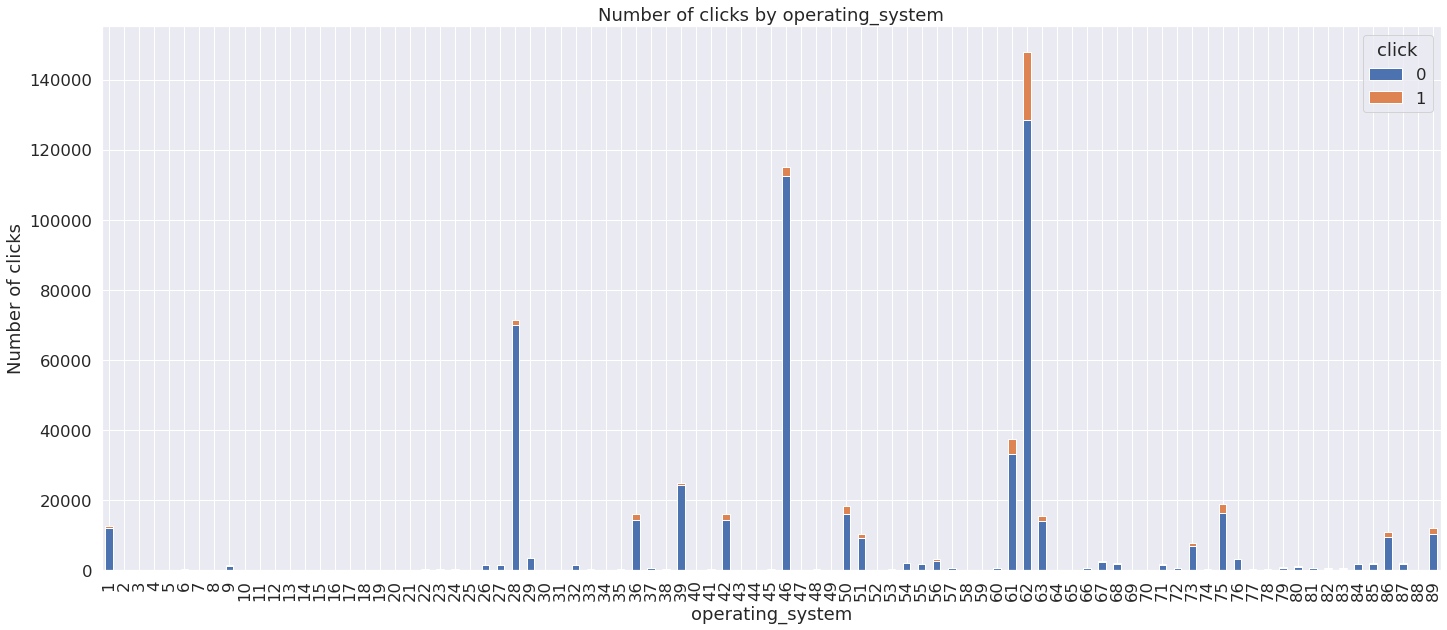

In [27]:
bar_chart(data, 'operating_system')

Au lieu de travailler avec 89 catégories de 'operating_system', on propose de garder juste le 28, 46 et 62 operating_system, tout le reste fera partie d'une même catégorie.

Le mapping final est le suivant:
    - catégorie (1) pour operating_system 62,
    - catégorie (2) pour operating_system 46,
    - catégorie (3) pour operating_system 28,
    - catégorie (0) pour le reste.

In [28]:
data['operating_system'].head()

0    46
1    89
2    87
3    28
4    28
Name: operating_system, dtype: int64

In [29]:
criteria = [
    data['operating_system'].isin([62]), data['operating_system'].isin([46]),
    data['operating_system'].isin([28])
]
values = [1, 2, 3]

data['operating_system'] = np.select(criteria, values, default=0)

In [30]:
data['operating_system'].head()

0    2
1    0
2    0
3    3
4    3
Name: operating_system, dtype: int64

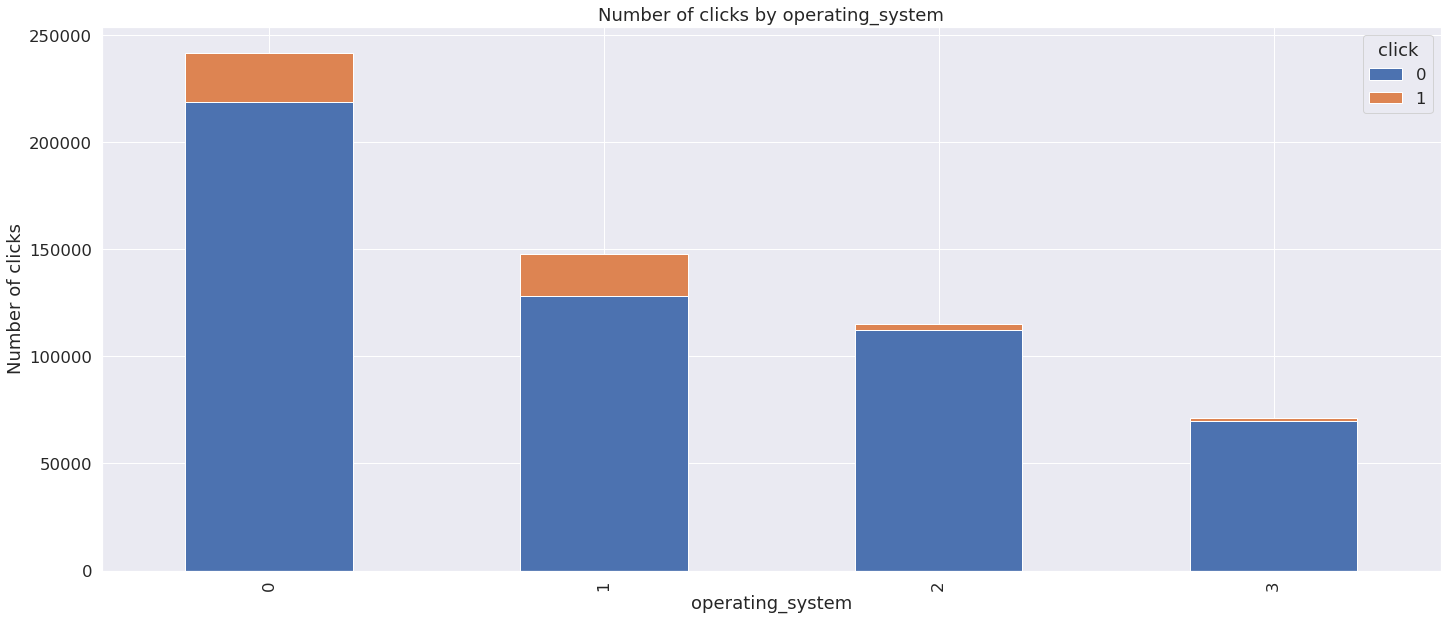

In [31]:
bar_chart(data, 'operating_system')

operating_system fera partie des features choisies vu son influence sur les clicks. 

### 3.4.4 browser

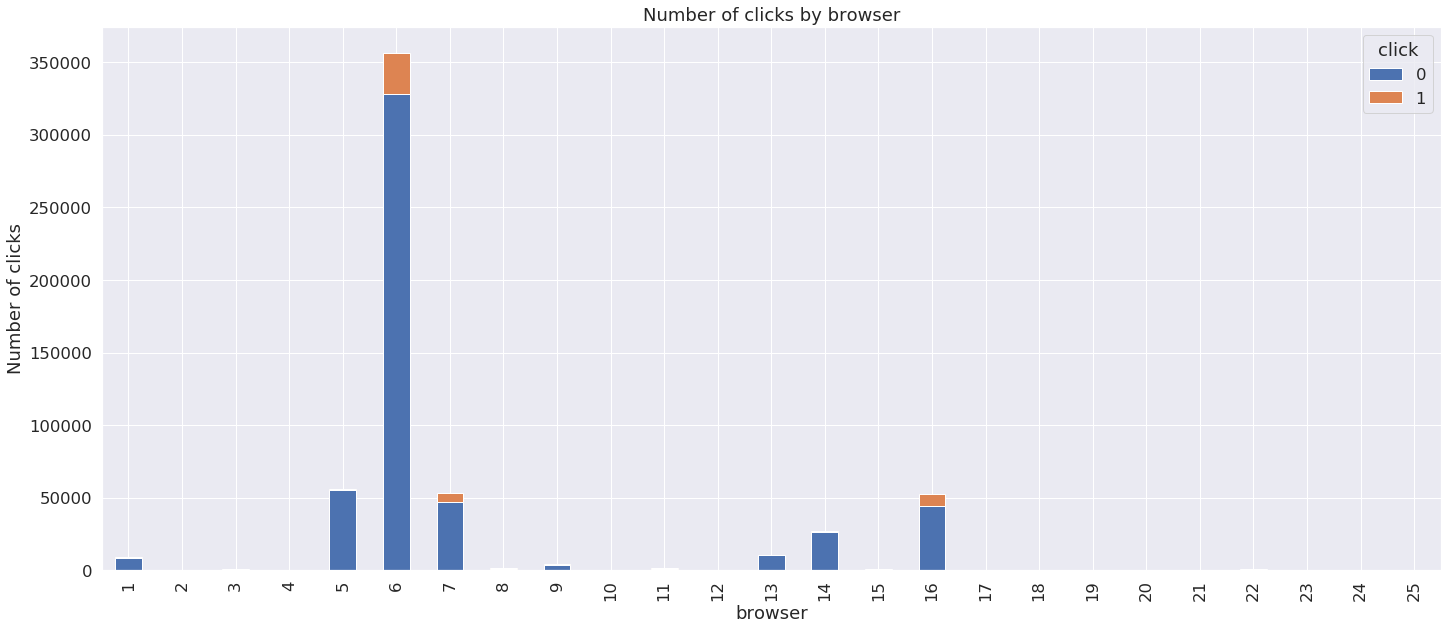

In [32]:
bar_chart(data, 'browser')

Au lieu de travailler avec 25 types de 'browser', on gardera juste le 6 comme catégorie (1), tout le reste sera mis dans une même catégorie (0).

In [33]:
data['browser'].head()

0    14
1     7
2     7
3     6
4     6
Name: browser, dtype: int64

In [34]:
criteria = [
    data['browser'].isin([6])
]
values = [1]

data['browser'] = np.select(criteria, values, default=0)

In [35]:
data['browser'].head()

0    0
1    0
2    0
3    1
4    1
Name: browser, dtype: int64

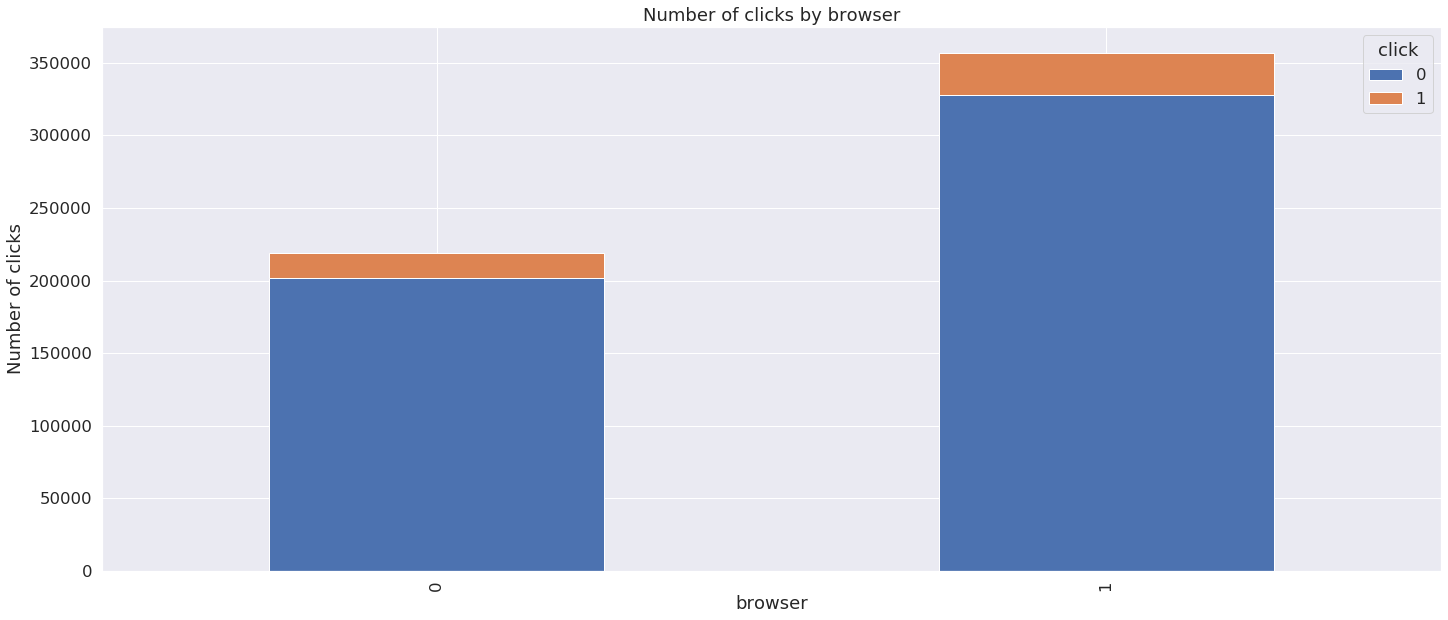

In [36]:
bar_chart(data, 'browser')

### 3.4.5 geo_dma

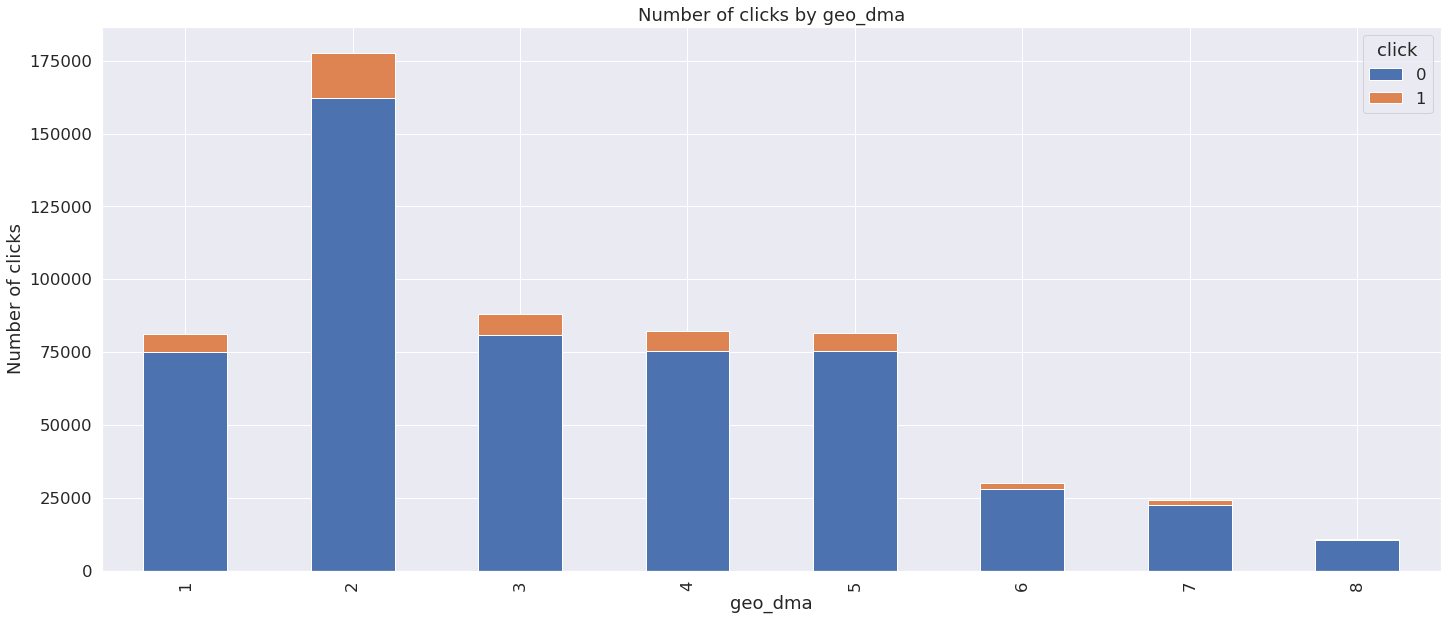

In [37]:
bar_chart(data, 'geo_dma')

Pour 'geo_dma', on propose de créer:
    - une catégorie (1) pour geo_dma=2
    - une catégorie (2) pour geo_dma dans {1, 3, 4, 5}
    - une catégorie (0) pour le reste

In [38]:
data['geo_dma'].head()

0    5
1    3
2    1
3    3
4    4
Name: geo_dma, dtype: int64

In [39]:
criteria = [
    data['geo_dma'].isin([2]), data['geo_dma'].isin([1, 3, 4, 5])
]
values = [1, 2]

data['geo_dma'] = np.select(criteria, values, default=0)

In [40]:
data['geo_dma'].head()

0    2
1    2
2    2
3    2
4    2
Name: geo_dma, dtype: int64

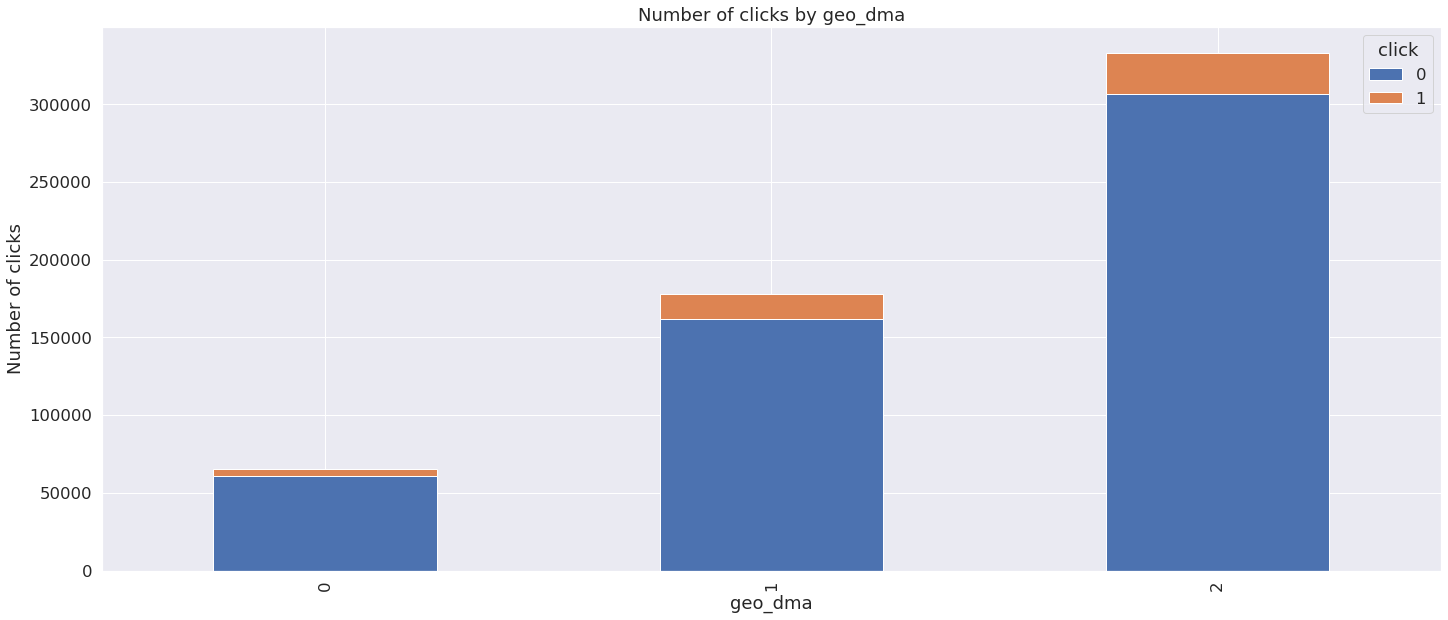

In [41]:
bar_chart(data, 'geo_dma')

### 3.4.6 device_type

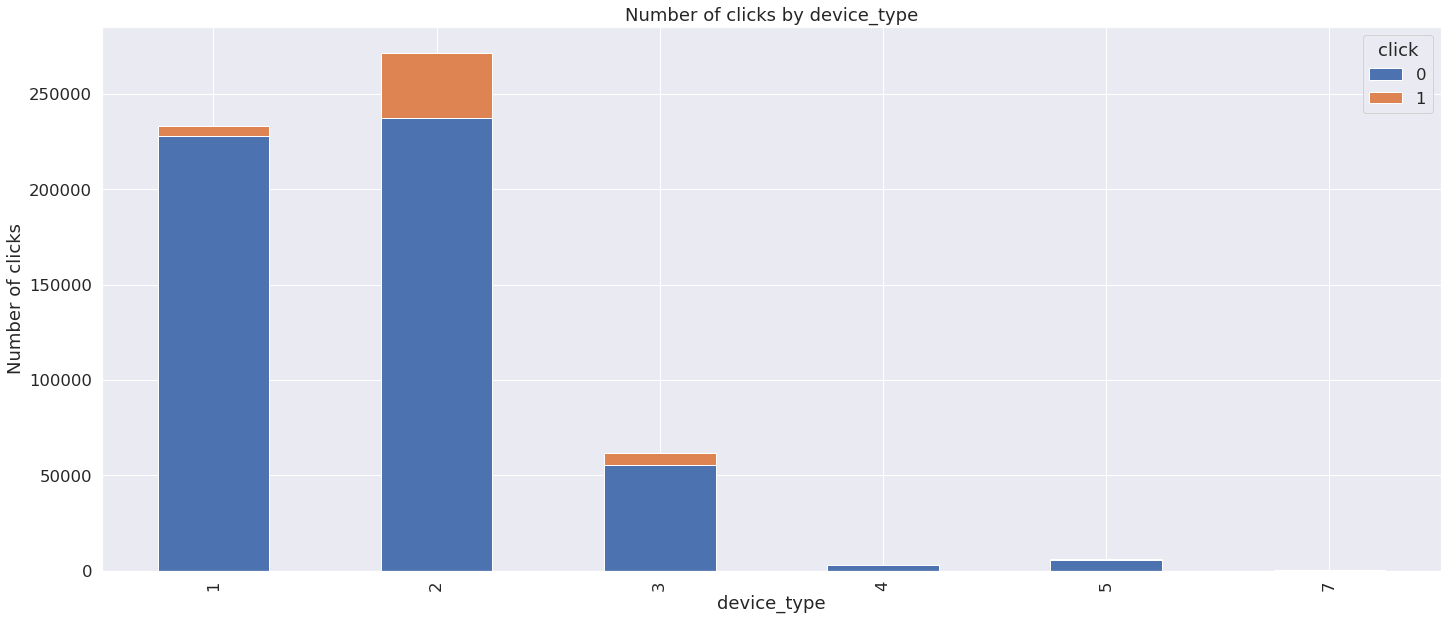

In [42]:
bar_chart(data, 'device_type')

On va garder le 1 et 2 'device_type', le reste sera mis dans une categorie 0.
On propose de créer:

    - une catégorie (1) pour device_type=1
    - une catégorie (2) pour device_type=2
    - une catégorie (0) pour le reste

In [43]:
data['device_type'].head()

0    1
1    2
2    2
3    1
4    1
Name: device_type, dtype: int64

In [44]:
criteria = [data['device_type'].isin([1]), data['device_type'].isin([2])]
values = [1, 2]

data['device_type'] = np.select(criteria, values, default=0)

In [45]:
data['device_type'].head()

0    1
1    2
2    2
3    1
4    1
Name: device_type, dtype: int64

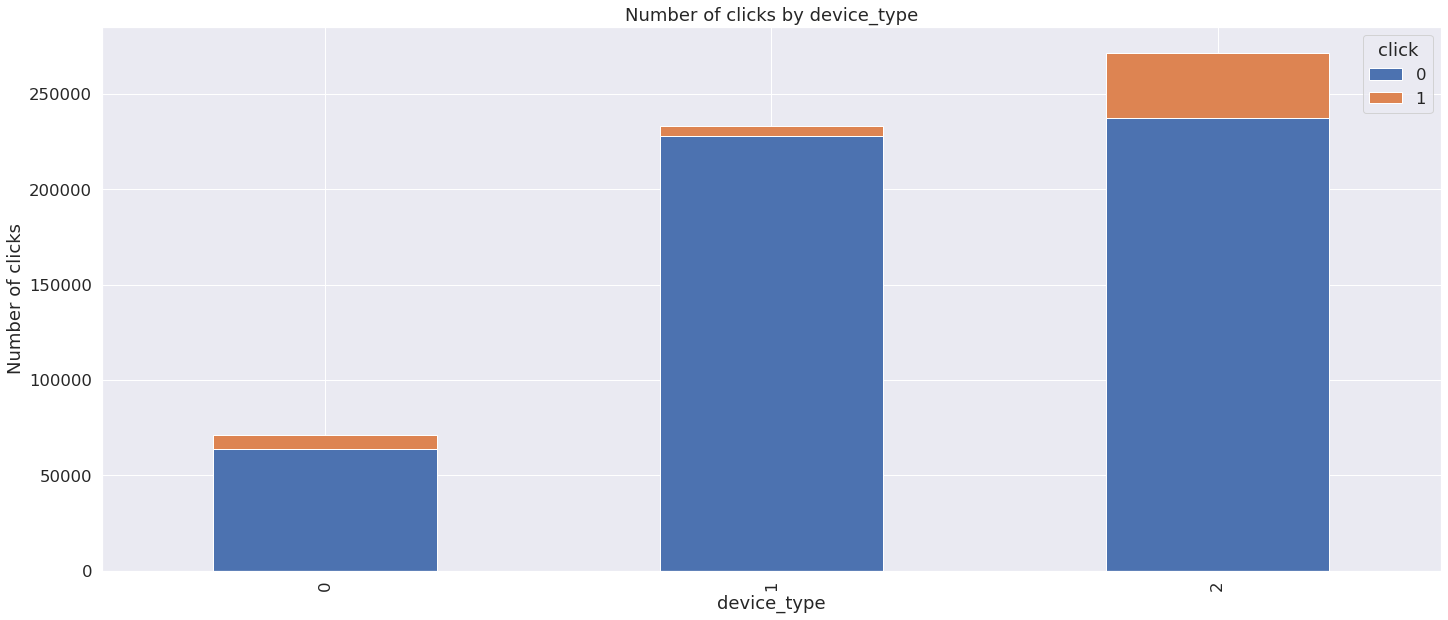

In [46]:
bar_chart(data, 'device_type')

## 3.5 Influence des variables quantitatives sur la variable d'intérêt 'click'

### 3.5.1 Matrice de corrélation entre les features quantitatives

In [47]:
quantitative_features_corr = data[[
    'buyer_bid', 'advertiser_frequency', 'advertiser_recency', 'creative_freq',
    'creative_rec'
]].corr()

quantitative_features_corr.style.background_gradient()

,buyer_bid,advertiser_frequency,advertiser_recency,creative_freq,creative_rec
buyer_bid,1,-0.044552,-0.0362129,-0.0562276,-0.0331939
advertiser_frequency,-0.044552,1,0.226023,0.6935,0.272327
advertiser_recency,-0.0362129,0.226023,1,0.209582,0.802951
creative_freq,-0.0562276,0.6935,0.209582,1,0.316765
creative_rec,-0.0331939,0.272327,0.802951,0.316765,1


On remarque:
    - 'buyer_id' est non corrélée avec les autres features. 
    - une corrélation assez importante entre 'advertiser_frequency' et 'creative_freq' qui vaut 0.6935.
    - une forte corrélation entre 'advertiser_recency' et 'creative_rec' valant 0.802951.

Du coup, dans la suite de notre analyse, on va garder juste les features non corrélées entre elles, à savoir: <b>'buyer_bid'</b>, <b>'advertiser_frequency'</b> et <b>'advertiser_recency'</b>. 

### 3.5.2 buyer_bid

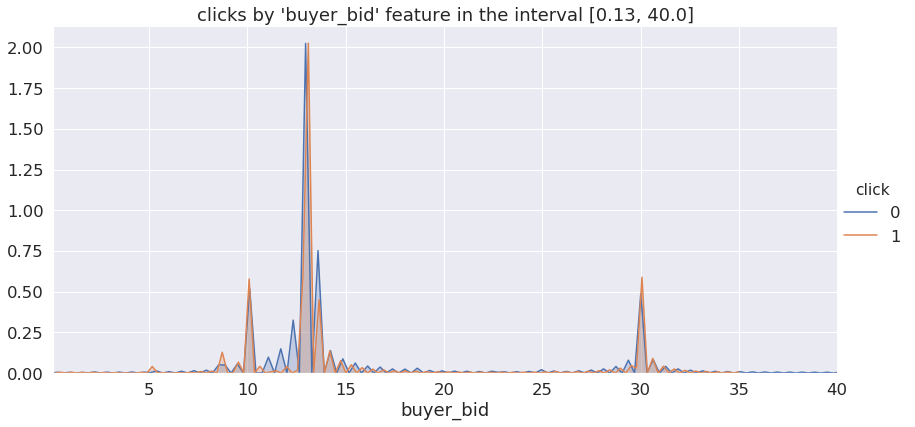

In [48]:
lattice_plot(data, 'buyer_bid')

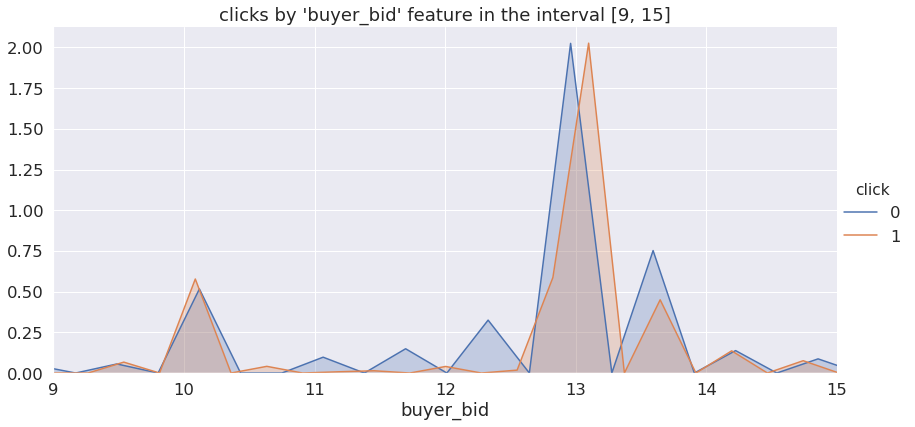

In [49]:
lattice_plot(data, 'buyer_bid', [9, 15])

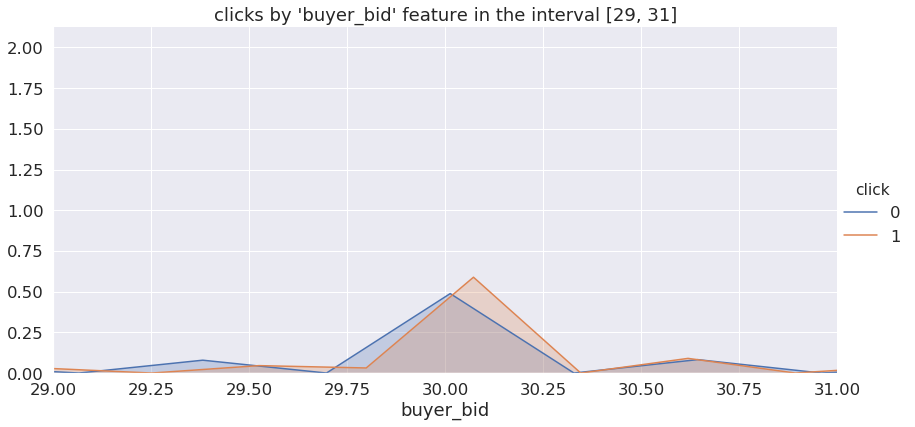

In [50]:
lattice_plot(data, 'buyer_bid', [29, 31])

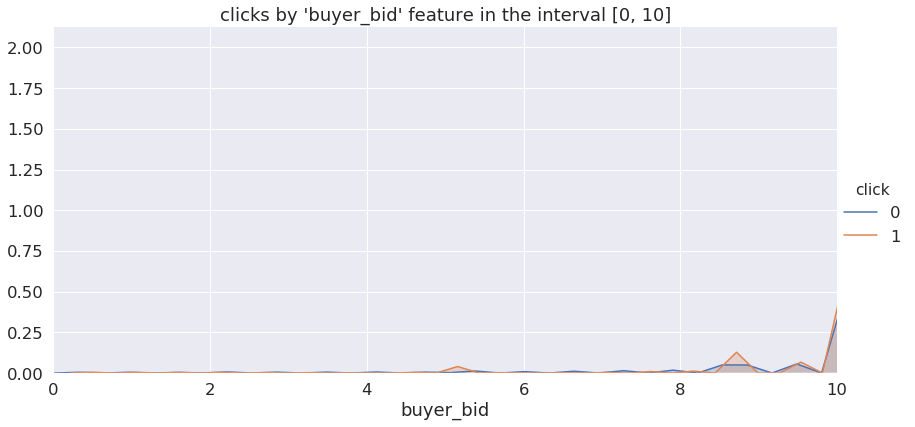

In [51]:
lattice_plot(data, 'buyer_bid', [0, 10])

On remarque que le nombre de clicks est influencé principalement pour un 'buyer_bid' situé dans les intervalles [9, 15] et [28, 32].

On peut appliquer une transformation de <b>binning</b> sur cette feature qui va consister à:
    - attribuer (1) pour 9 <= 'buyer_bid' <= 15
    - attribuer (2) pour 29 <= 'buyer_bid' <= 31
    - attribuer (0) pour le reste

Pour se retrouver au final avec une feature catégorique.

In [52]:
data['buyer_bid'].head()

0    14.00
1    13.70
2    10.00
3    18.71
4     6.61
Name: buyer_bid, dtype: float64

In [53]:
criteria = [data['buyer_bid'].between(9, 15), data['buyer_bid'].between(29, 31)]
values = [1, 2]

data['buyer_bid'] = np.select(criteria, values, default=0)

In [54]:
data['buyer_bid'].head()

0    1
1    1
2    1
3    0
4    0
Name: buyer_bid, dtype: int64

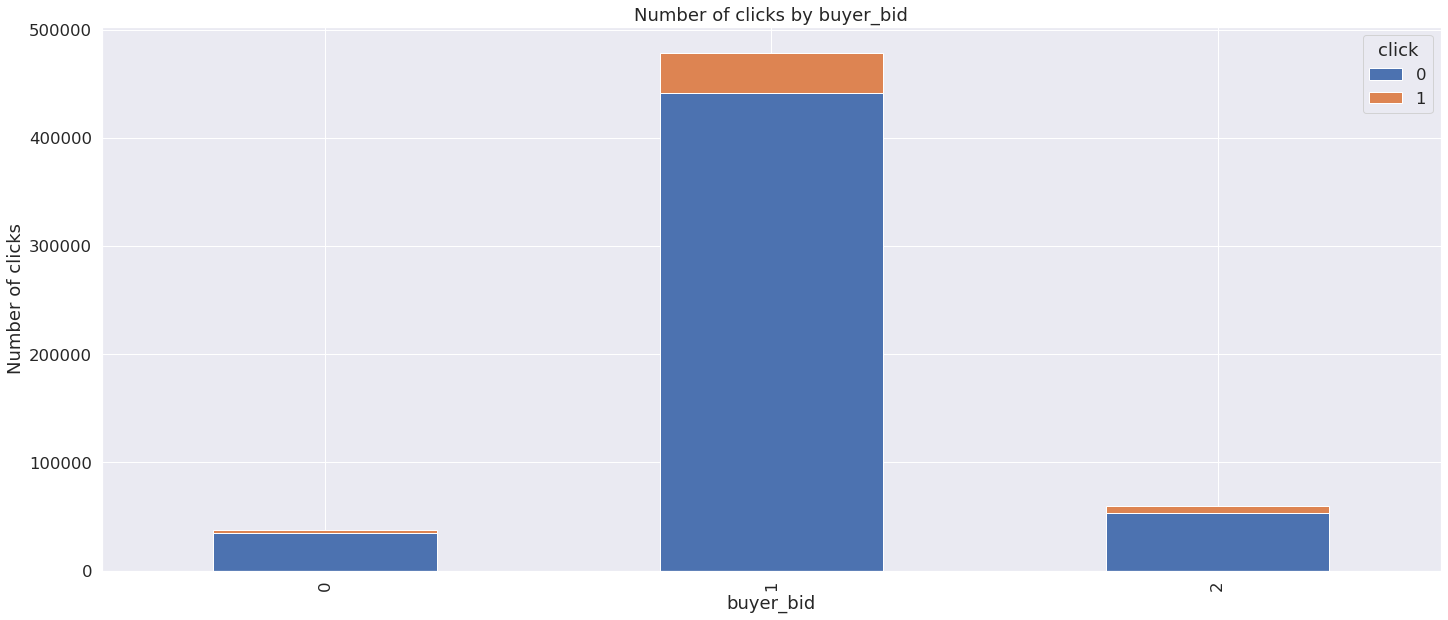

In [55]:
bar_chart(data, 'buyer_bid')

### 3.5.3 advertiser_frequency

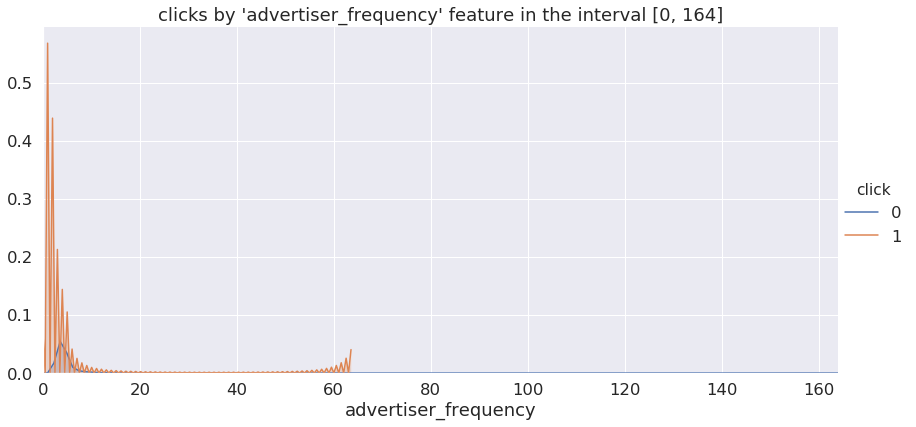

In [56]:
lattice_plot(data, 'advertiser_frequency')

On peut zoomer sur un intervalle bien spécifique pour voir ce qui se passe de plus prêt. Prenons par exemple, l'intervalle [0, 10]

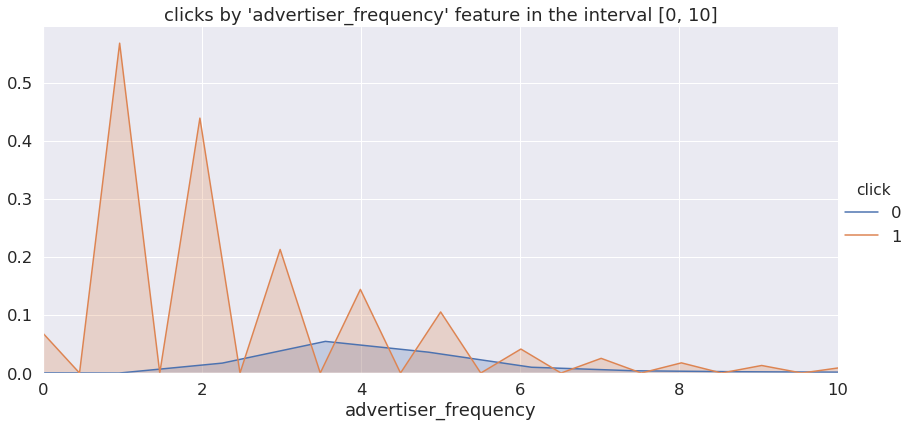

In [57]:
lattice_plot(data, 'advertiser_frequency', [0, 10])

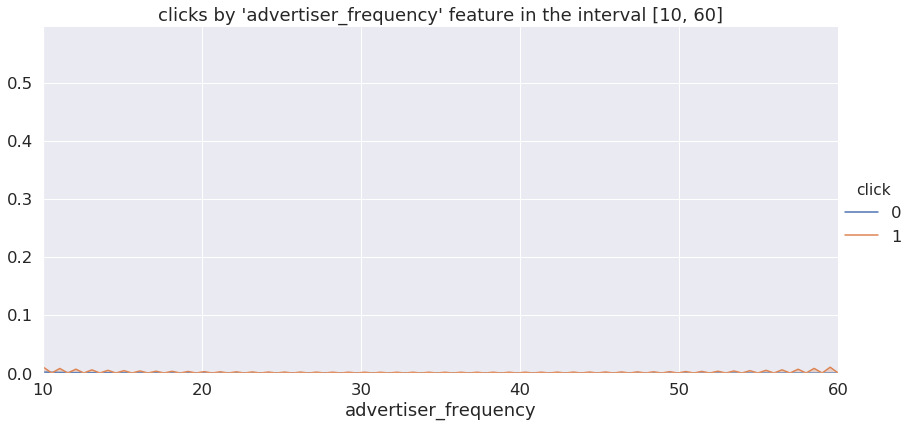

In [58]:
lattice_plot(data, 'advertiser_frequency', [10, 60])

D'après les plots précedents, on remarque que le nombre de clicks est assez important pour des 'advertiser_frequency' < 10, tandis que pour 'advertiser_frequency' > 10, le nombre de clicks enregistré n'est plus influé par cette feature. 

On peut dire que l'espace peut être divisé en deux régions, la première pour 'advertiser_frequency' < 10 et la deuxième 'advertiser_frequency' > 10. Du coup on peut appliquer une transformation de <b>binning</b> sur cette feature qui va consister à:
    - attribuer (1) pour 'advertiser_frequency' <= 10
    - attribuer (0) pour 'advertiser_frequency' > 10

Pour se retrouver au final avec une feature catégorique.

In [59]:
data['advertiser_frequency'].head()

0    1
1    3
2    2
3    2
4    2
Name: advertiser_frequency, dtype: int64

In [60]:
criteria = [data['advertiser_frequency'].between(0, 10)]
values = [1]

data['advertiser_frequency'] = np.select(criteria, values, default=0)

In [61]:
data['advertiser_frequency'].head()

0    1
1    1
2    1
3    1
4    1
Name: advertiser_frequency, dtype: int64

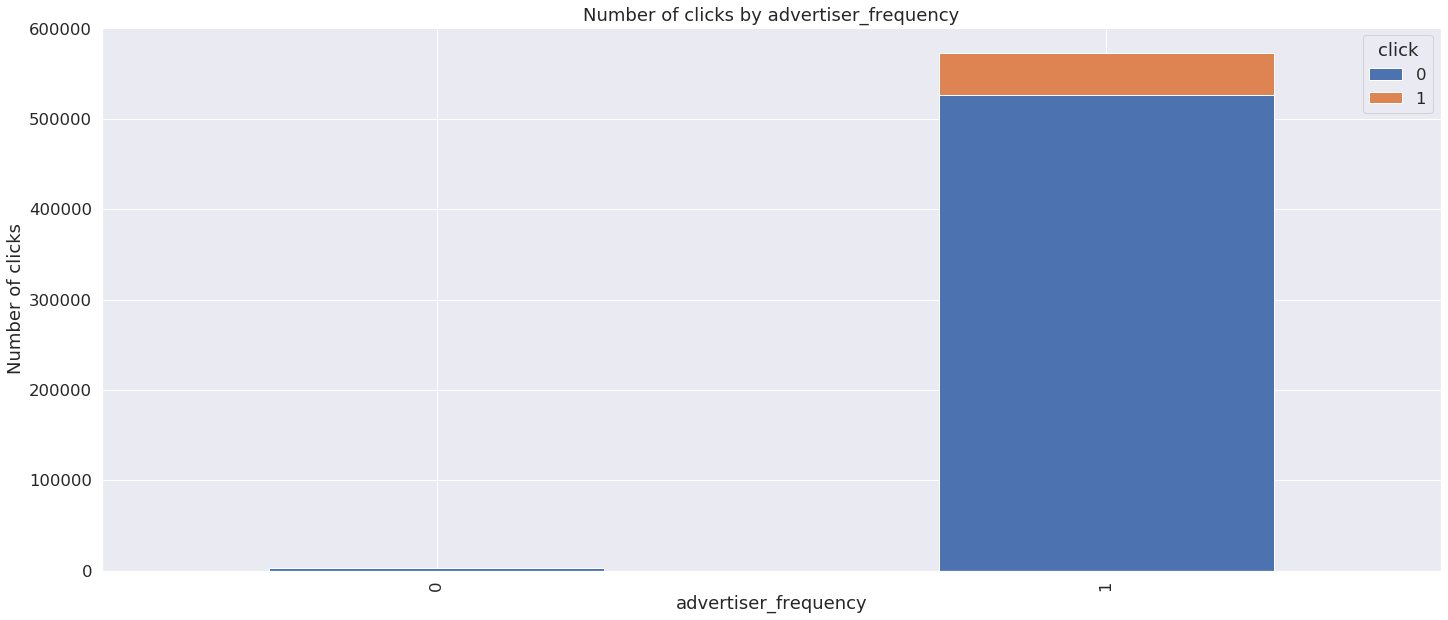

In [62]:
bar_chart(data, 'advertiser_frequency')

### 3.5.4 advertiser_recency

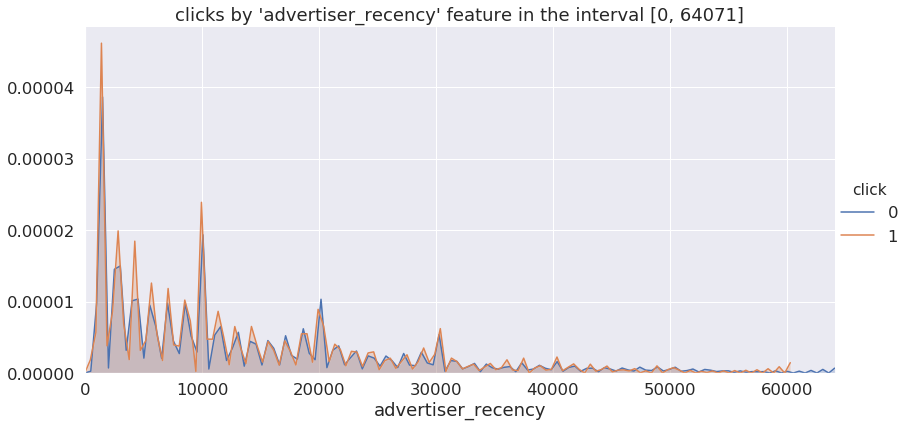

In [63]:
lattice_plot(data, 'advertiser_recency')

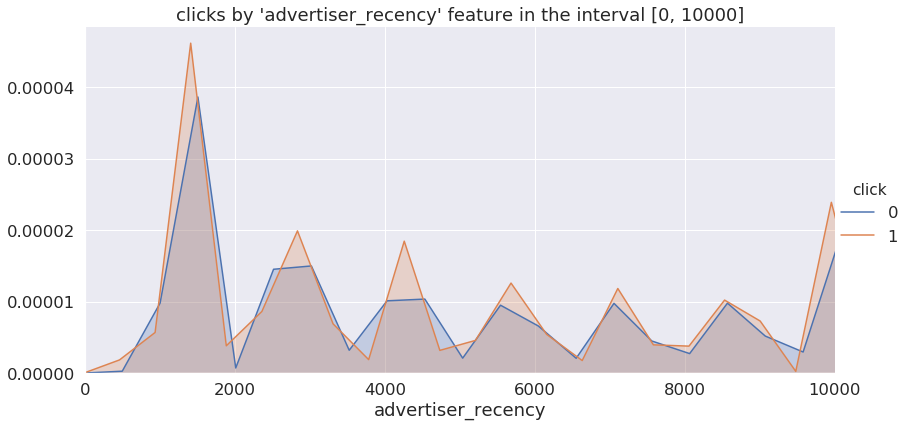

In [64]:
lattice_plot(data, 'advertiser_recency', [0, 10000])

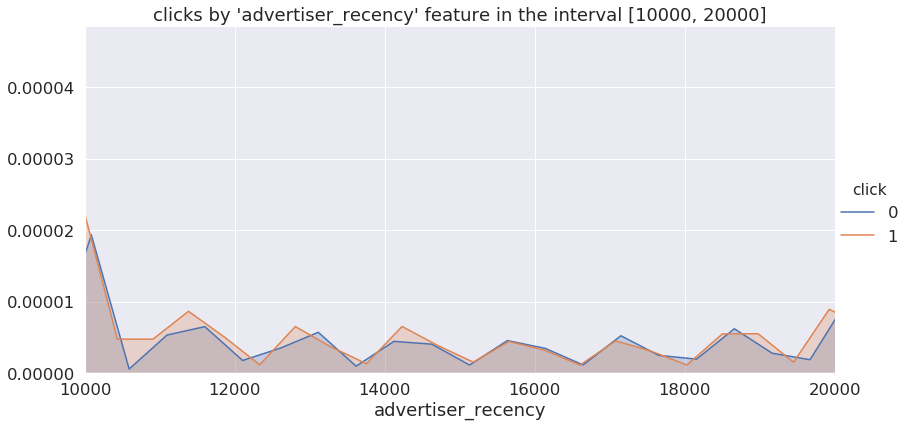

In [65]:
lattice_plot(data, 'advertiser_recency', [10000, 20000])

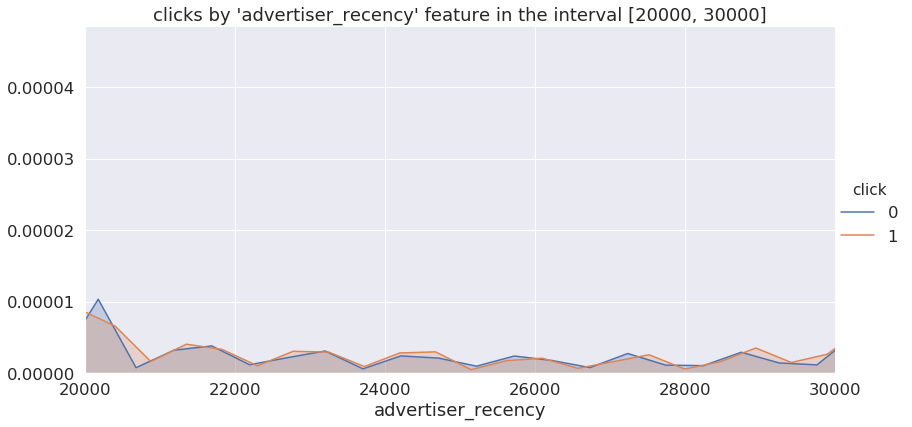

In [66]:
lattice_plot(data, 'advertiser_recency', [20000, 30000])

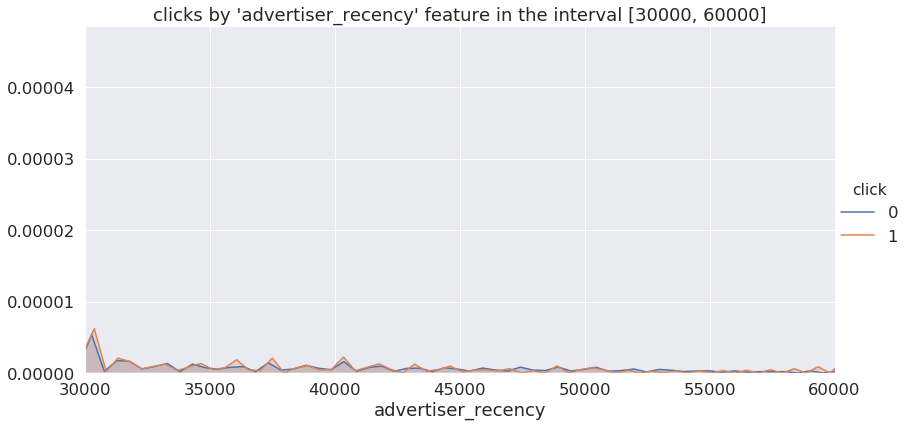

In [67]:
lattice_plot(data, 'advertiser_recency', [30000, 60000])

On remarque que le nombre de clicks varie avec la variation de cette feature. Du coup on va la conserver tout en la normalisant.

## 3.6 Conclusion sur le choix des features

### Features catégoriques

On remarque que toutes les variables catégoriques vues en paragraphe 3.4 influent sur le 'click'. En prenant en compte les features numériques sur lesquelles on a appliqué un binning, on se retrouve donc avec 8 features catégoriques, à savoir:
    - fold_position
    - geo_region
    - operating_system
    - browser
    - geo_dma
    - device_type
    - buyer_bid
    - advertiser_frequency

### Features quantitatives

    - advertiser_recency

# 4 Préparation du jeu de données final pour la phase d'entraînement

## 4.1 Extraction du jeu de données final

In [68]:
# liste des features qui ont été sélectionnées
features = [
    'fold_position', 'buyer_bid', 'geo_region', 'operating_system', 'browser',
    'advertiser_frequency', 'advertiser_recency', 'geo_dma', 'device_type'
]

In [69]:
X = data[features]
y = data['click'] 

## 4.2 Dummy coding des features catégoriques

In [70]:
categorical_features = [
    'fold_position', 'buyer_bid', 'geo_region', 'operating_system', 'browser',
    'advertiser_frequency', 'geo_dma', 'device_type'
]

In [71]:
# dummy coding du dataframe à l'aide de la fonction définie dans le paragraphe 2.Utils
X = dummy_df(X, categorical_features)

In [72]:
X.head()

,advertiser_recency,fold_position_0,fold_position_1,buyer_bid_0,buyer_bid_1,buyer_bid_2,geo_region_0,geo_region_1,geo_region_2,operating_system_0,...,browser_0,browser_1,advertiser_frequency_0,advertiser_frequency_1,geo_dma_0,geo_dma_1,geo_dma_2,device_type_0,device_type_1,device_type_2
0,7,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0
1,38781,0,1,0,1,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1
2,1,0,1,0,1,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1
3,34,1,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
4,1,1,0,1,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,1,0


# 5 Entraînement des modèles

## 5.1 Métrique pour mesurer la performance des modèles

On veut à la fois:
    - Eviter de prédire un client non intéressé (qui ne va pas cliquer) comme étant un intéressé, i.e. minimiser le nombre de False Positives (FP).
    - Eviter de prédire un client intéressé (qui va cliquer) comme étant non intéressé, i.e. minimiser le nombre de False Negatives (FN).
Autrement dit, on veut à la fois minimiser FP et FN et donc à la fois maximiser la Precision et le Recall.

La métrique qu'on va donc utiliser pour mesurer la performance des modèles est le <b>F1-Score</b>, avec comme objectif de le maximiser.

In [73]:
from sklearn.metrics import f1_score

## 5.2 Train/test split

On va subdiviser notre jeu de données (X, y) en 2 sets:
    - Training set (80%) qu'on va équilibrer dans le prochain paragraphe.
    - Test set (20%)

In [75]:
from sklearn.model_selection import train_test_split

np.random.seed(999) # pour la reproductibilité des résultats

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

# Réinitialisation des indices pour éviter l'apparition de certaines exceptions par la suite
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [76]:
X_train.shape

(460768, 23)

## 5.3 Normalisation de la feature quantitative

In [77]:
train_mean = X_train['advertiser_recency'].mean()
train_std = X_train['advertiser_recency'].std()

In [78]:
X_train['advertiser_recency'].describe()

count    460768.000000
mean       2256.186374
std        7103.073612
min           0.000000
25%           0.000000
50%           2.000000
75%          42.000000
max       64071.000000
Name: advertiser_recency, dtype: float64

In [79]:
X_test['advertiser_recency'].describe()

count    115193.000000
mean       2252.103348
std        7129.732254
min           0.000000
25%           0.000000
50%           2.000000
75%          42.000000
max       63292.000000
Name: advertiser_recency, dtype: float64

In [80]:
# Normalisation
X_train['advertiser_recency'] = (X_train['advertiser_recency'] - train_mean) / train_std
X_test['advertiser_recency'] = (X_test['advertiser_recency'] - train_mean) / train_std 

In [81]:
X_train['advertiser_recency'].describe()

count    4.607680e+05
mean     1.810910e-15
std      1.000000e+00
min     -3.176352e-01
25%     -3.176352e-01
50%     -3.173537e-01
75%     -3.117223e-01
max      8.702544e+00
Name: advertiser_recency, dtype: float64

In [82]:
X_test['advertiser_recency'].describe()

count    115193.000000
mean         -0.000575
std           1.003753
min          -0.317635
25%          -0.317635
50%          -0.317354
75%          -0.311722
max           8.592874
Name: advertiser_recency, dtype: float64

La normalisation a bien été effectuée.

## 5.4 Correction du déséquilibre dans le jeu de données d'entraînement

On va vu dans le paragraphe 3.3 que notre jeu de données souffrait d'un déséquilibre de classes. En effet, seulement 8% des pubs ont enregistré un click. 

On va procéder donc à un équilibrage du jeu de données d'entraînement (X_train, y_train) en créant des observations synthétiques de la classe minoritaire en utilisant l'algorithme <b>SMOTE</b> (Synthetic Minority Oversampling Technique) disponible dans la bibliothèque imblearn.

In [83]:
clicks_mean_before_balancing = y_train.mean()
print("Moyenne des clicks avant équilibrage = {0:.0%}".format(clicks_mean_before_balancing))

Moyenne des clicks avant équilibrage = 8%


In [85]:
# Equilibrage du jeu de données d'entraînement avant d'alimenter les modèles
from imblearn.over_sampling import SMOTE

# Extraction des colonnes de X_train parce qu'on va les perdre après application du SMOTE
x_cols = X_train.columns

sm = SMOTE(ratio=1.0)

In [86]:
# fitting smote
X_train, y_train = sm.fit_sample(X_train, y_train)

In [87]:
# Restructurer le training set
X_train = pd.DataFrame(X_train, columns=x_cols)
y_train = pd.Series(y_train)

In [88]:
clicks_mean_after_balancing = y_train.mean()
print("Moyenne des clicks après équilibrage = {0:.0%}".format(clicks_mean_after_balancing))

Moyenne des clicks après équilibrage = 50%


## 5.5 Random forests (RF)

In [89]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [90]:
# prediction making on train/test sets
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [91]:
# random forests performace
rf_performance = {'train': f1_score(y_train, pred_train),
                 'test': f1_score(y_test, pred_test)}

In [92]:
rf_performance

{'train': 0.8220416071457891, 'test': 0.24904676294525557}

## 5.6 Régression logistique (LR)

In [93]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', max_iter=100)

In [94]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [95]:
# prediction making on train/test sets
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [96]:
# logistic regression performace
lr_performance = {'train': f1_score(y_train, pred_train),
                 'test': f1_score(y_test, pred_test)}

In [97]:
lr_performance

{'train': 0.7521329299925702, 'test': 0.24527769108445915}

## 5.7 Réseau de neurones MLP

In [98]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()

In [99]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [100]:
# prediction making on train/test sets
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [101]:
# MLP performace
mlp_performance = {'train': f1_score(y_train, pred_train),
                 'test': f1_score(y_test, pred_test)}

In [102]:
mlp_performance

{'train': 0.7525241265728718, 'test': 0.24516745839682114}

## 5.8 Comparaison des performances et conclusion

In [103]:
# dataframe récapitulatif des performances
models_performance = pd.DataFrame({'Training F1 score': [rf_performance['train'], 
                                                        lr_performance['train'],
                                                        mlp_performance['train']],
                                   'Test F1 score': [rf_performance['test'],
                                                    lr_performance['test'],
                                                    mlp_performance['test']]})
models_performance.index = ['RF', 'LR', 'MLP']

In [104]:
models_performance

,Training F1 score,Test F1 score
RF,0.822042,0.249047
LR,0.752133,0.245278
MLP,0.752524,0.245167


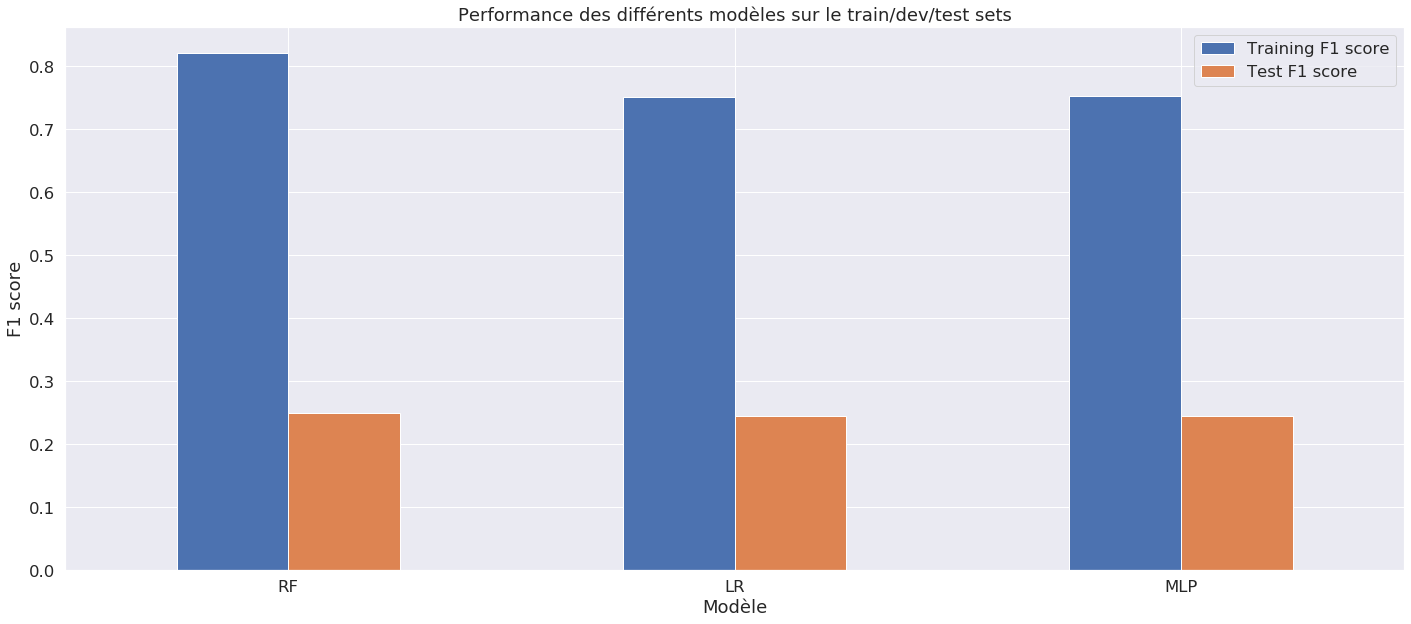

In [105]:
models_performance.plot(kind='bar', rot=0)
plt.title('Performance des différents modèles sur le train/dev/test sets')
plt.xlabel('Modèle')
plt.ylabel('F1 score')
plt.show()

**Conclusion**

Les modèles LR et MLP ont des performances assez similaires. Tandis que les RF ont enregistré le meilleur F1 score pour le test set.

Toutefois tous ces modèles souffrent d'un overfitting avec des degrés assez similaires (Training F1_score > Test F1_Score). Ceci est dû principalement au déséquilibre de classes du jeu de données et de la technique de rééchantillonnage utilisée. 

Pour réduire cet overfitting, on peut donc essayer de:
    - tester d'autres techniques plus sophistiquées de rééchantillonnage, ou faire une combinaison à la fois d'undersampling de la classe majoritaire et d'oversampling de la classe minoritaire. 
    - réduire le nombre de features utilisées.
    - introduire des techniques de régularisation (L1, L2 par exemple ou early stopping), et dropout pour le cas du MLP.